# Using Compose with Featuretools
In this guide, we will generate a labeled feature matrix from a mock dataset of transactions using ComposeML and Featuretools. Then create a machine learning model for predicting whether customers will spend over $750 within the next 15 minutes.

## Load Data

In [1]:
import featuretools as ft

transactions = ft.demo.load_mock_customer(
    return_single_table=True,
    random_seed=0,
)

transactions[transactions.columns[:5]].head()

,transaction_id,session_id,transaction_time,product_id,amount
0,298,1,2014-01-01 00:00:00,5,127.64
1,10,1,2014-01-01 00:09:45,5,57.39
2,495,1,2014-01-01 00:14:05,5,69.45
3,460,10,2014-01-01 02:33:50,5,123.19
4,302,10,2014-01-01 02:37:05,5,64.47


## Create Labels

### Define Labeling Function

In [2]:
def my_labeling_function(df_slice):
    label = df_slice["amount"].sum()
    return label

### Construct Label Maker

In [3]:
from composeml import LabelMaker

label_maker = LabelMaker(
    target_entity='customer_id',
    time_index='transaction_time',
    labeling_function=my_labeling_function,
    window_size='15min',
)

### Generate Labels

In [4]:
labels = label_maker.search(
    transactions,
    minimum_data='15min',
    num_examples_per_instance=50,
    gap='2min',
)

labels = labels.threshold(750)

labels.describe()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|████████████████████| customer_id: 5/5 

Label Distribution
------------------
False     111
True      105
Total:    216


Settings
--------
gap                           2min
minimum_data                 15min
num_examples_per_instance       50
window_size                  15min


Transforms
----------
1. threshold
  - value:    750




## Create Entity Set

### Construct Entity Set

In [5]:
es = ft.EntitySet('transactions')

es.entity_from_dataframe(
    'transactions',
    transactions,
    index='transaction_id',
    time_index='transaction_time',
)

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 12]
  Relationships:
    No relationships

### Normalize Entities

In [6]:
es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='sessions',
    index='session_id',
    make_time_index='session_start',
    additional_variables=[
        'device',
        'customer_id',
        'zip_code',
        'session_start',
        'join_date',
        'date_of_birth',
    ],
)

es.normalize_entity(
    base_entity_id='sessions',
    new_entity_id='customers',
    index='customer_id',
    make_time_index='join_date',
    additional_variables=[
        'zip_code',
        'join_date',
        'date_of_birth',
    ],
)

es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='products',
    index='product_id',
    additional_variables=['brand'],
    make_time_index=False,
)

es.add_last_time_indexes()

### Plot Entity Set

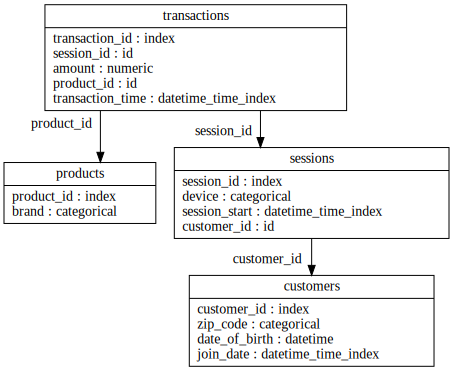

In [7]:
es.plot()

## Create Feature Matrix

### Generate Feature Matrix

In [8]:
feature_matrix, fd = ft.dfs(
    entityset=es,
    target_entity='customers',
    agg_primitives=[
        'min',
        'mean',
        'max',
        'sum',
        'std',
        'trend',
    ],
    trans_primitives=[
        'cum_min',
        'cum_mean',
        'cum_max',
        'cum_sum',
    ],
    cutoff_time=labels,
    cutoff_time_in_index=True,
    verbose=True,
)

Built 63 features
Elapsed: 01:23 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


### Split Feature Matrix

In [9]:
from sklearn.model_selection import train_test_split

feature_matrix = feature_matrix.fillna(0)

x_train, x_test = train_test_split(
    feature_matrix,
    train_size=.8,
    test_size=.2,
)

y_train = x_train.pop(labels.name)
y_test = x_test.pop(labels.name)


info = '{} Set\n' + '-' * 10 + '\nx: {}\ny: {}'
print(info.format('Train', x_train.shape, y_train.shape), end='\n\n')
print(info.format('Test', x_test.shape, y_test.shape))

Train Set
----------
x: (172, 63)
y: (172,)

Test Set
----------
x: (44, 63)
y: (44,)


## Create Model

### Construct Model

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)

### Train Model

In [11]:
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Test Model

In [12]:
from sklearn.metrics import classification_report

y_hat = clf.predict(x_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.76      0.73      0.74        22
        True       0.74      0.77      0.76        22

    accuracy                           0.75        44
   macro avg       0.75      0.75      0.75        44
weighted avg       0.75      0.75      0.75        44

